In [19]:
import torch
import numpy as np

In [2]:
# Load Data
clean_pt = torch.load('/Users/aideenfay/dev/gh/mang0kitty/ethical-ai-activations/test_data/mistral/clean_hidden_states_0_1000_20240422_185013.pt')
poisoned_pt = torch.load('/Users/aideenfay/dev/gh/mang0kitty/ethical-ai-activations/test_data/mistral/poisoned_hidden_states_0_1000_20240423_011421.pt')




In [3]:
clean = clean_pt[1, :, :, :] - clean_pt[0, :, :, :]
poisoned = poisoned_pt[1, :, :, :] - poisoned_pt[0, :, :]
print(clean.shape)
print(poisoned.shape)

torch.Size([1000, 32, 4096])
torch.Size([1000, 32, 4096])


In [4]:
LAYERS = [1, 7, 15, 24, 31]

In [17]:
clean_reduced = clean[:200, :, :]
clean_reduced.shape

torch.Size([200, 32, 4096])

In [18]:
poisoned_reduced = poisoned[:200, :, :]

In [20]:
np.savez_compressed('clean_reduced.npz', clean_reduced)
np.savez_compressed('poisoned_reduced.npz', poisoned_reduced)

# Exploring LLM Interpretability: PCA, t-SNE, TDA, Probing, and Sparse Autoencoders
This tutorial will guide you through several techniques to analyze and interpret differences in large language model (LLM) representations. We will use a **clean** vs **poisoned** dataset of activations (shape `(200, 32, 4096)`) as an example. "Poisoned" data refers to model representations that have been influenced by an Extended Prompt Injection Attack (XPIA), whereas "clean" data has no such influence. By comparing these, we can learn how various mathematical tools reveal structure in high-dimensional data.

The notebook is structured into five sections:
1. **Principal Component Analysis (PCA)**
2. **t-Distributed Stochastic Neighbor Embedding (t-SNE)**
3. **Persistent Homology (Topological Data Analysis)**
4. **Logistic Regression Probe**
5. **Sparse Autoencoder (SAE)**

Each section will introduce the concept, provide code templates (with some parts for you to fill in), and pose reflection questions and follow-up tasks. The code includes inline comments to help you understand each step. 

Let's get started!


## Load and Understand Data

In [28]:
import numpy as np

clean_data = np.load("clean_reduced.npz")['arr_0']
poisoned_data = np.load("poisoned_reduced.npz")['arr_0']


(200, 32, 4096)
(200, 32, 4096)


In [26]:
# TODO: Print the shape of the data
# The shape of the data is (200, 32, 4098)
# 200 is the number of samples
# 32 is the number of layers
# 4098 is the number of hidden units in each layer

print(clean_data.shape)
print(poisoned_data.shape)

(200, 32, 4096)

### TASK #1
Loop through the layers and calculate the cosine similarity between points within each class (i.e. pairwise distance between points within a class - once for the "clean" class and another for teh "poisoned" class. 


Clean data shape: (200, 32, 4096)
Poisoned data shape: (200, 32, 4096)


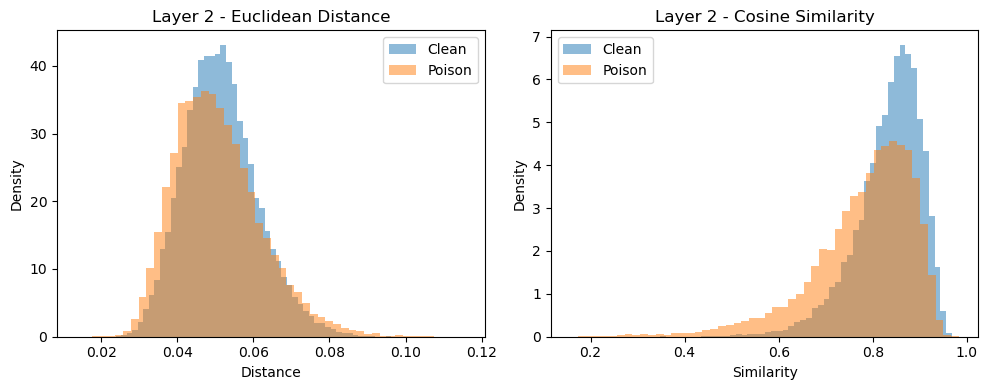

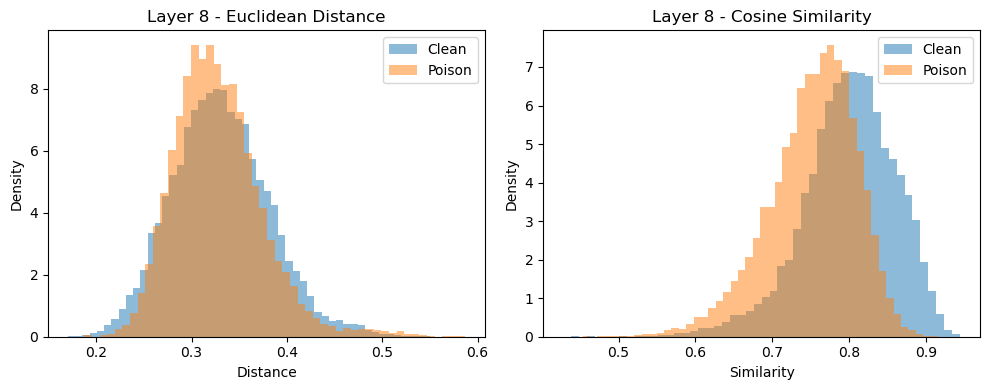

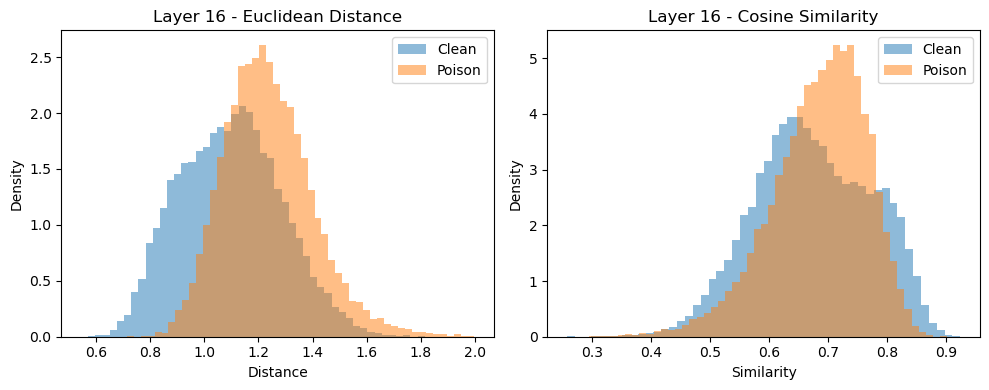

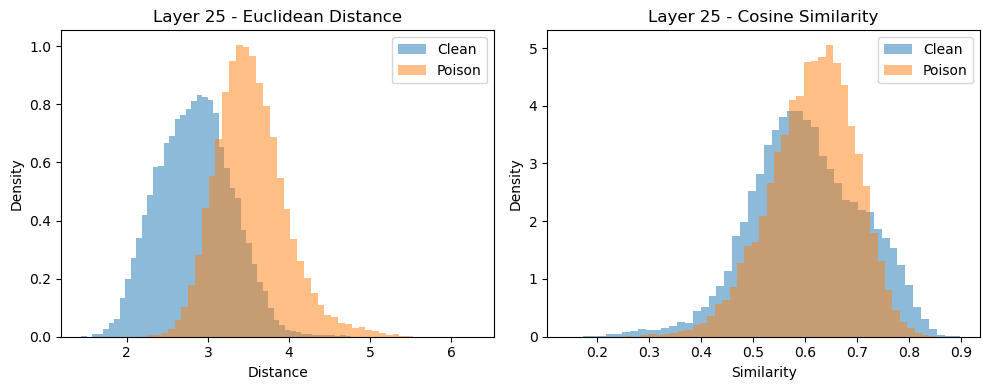

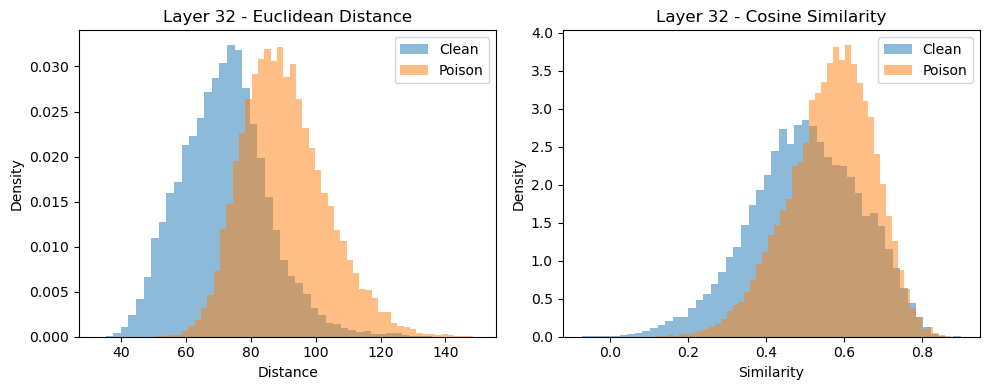

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

# Helper: Flatten upper-triangle of NxN matrix (excluding diagonal).
# This avoids double-counting symmetrical entries and self-distances.
def flatten_upper_tri(matrix):
    r, c = np.triu_indices(matrix.shape[0], k=1)
    return matrix[r, c]

# Compute both Cosine and Euclidean distance distributions for each layer
def plot_distance_distributions(clean_data, poisoned_data, LAYERS=[1, 7, 15, 24, 31]):
    """
    Args:
      clean_data:   (N, L, H) array of clean samples
      poisoned_data:(N, L, H) array of poisoned samples
    """
    num_samples, num_layers, num_hidden = clean_data.shape
    print(f"Clean data shape: {clean_data.shape}")
    print(f"Poisoned data shape: {poisoned_data.shape}")

    for layer_idx in LAYERS:
        # 1) Extract all samples for layer 'layer_idx'
        clean_layer = clean_data[:, :, :]     # shape (N, H)
        poisoned_layer = poisoned_data[:, :, :] # shape (N, H)

        # 2) Compute pairwise distances
        clean_cos_sim = cosine_similarity(clean_layer)    # NxN
        poison_cos_sim = cosine_similarity(poisoned_layer)

        # For Euclidean distance:
        clean_euc_dist = pairwise_distances(clean_layer, metric='euclidean')
        poison_euc_dist = pairwise_distances(poisoned_layer, metric='euclidean')

        # 3) Flatten upper-triangle to get 1D array of pairwise distances
        clean_cos_flat = flatten_upper_tri(clean_cos_sim)
        poison_cos_flat = flatten_upper_tri(poison_cos_sim)
        clean_euc_flat = flatten_upper_tri(clean_euc_dist)
        poison_euc_flat = flatten_upper_tri(poison_euc_dist)

        # 5) Plot side-by-side subplots
        plt.figure(figsize=(10,4))

        # Left Subplot: Euclidean distance
        plt.subplot(1, 2, 1)
        plt.hist(clean_euc_flat, bins=50, alpha=0.5, density=True, label='Clean')
        plt.hist(poison_euc_flat, bins=50, alpha=0.5, density=True, label='Poison')
        plt.title(f'Layer {layer_idx + 1} - Euclidean Distance')
        plt.xlabel('Distance')
        plt.ylabel('Density')
        plt.legend()

        # Right Subplot: Cosine similarity
        plt.subplot(1, 2, 2)
        plt.hist(clean_cos_flat, bins=50, alpha=0.5, density=True, label='Clean')
        plt.hist(poison_cos_flat, bins=50, alpha=0.5, density=True, label='Poison')
        plt.title(f'Layer {layer_idx + 1} - Cosine Similarity')
        plt.xlabel('Similarity')
        plt.ylabel('Density')
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_distance_distributions(clean_data, poisoned_data)


### Interpretation

* If the Euclidean distribution for clean is narrower or shifted compared to the poisoned distribution, it implies that the clean samples are more/less spread out.
* Likewise, the Cosine distribution reveals how angles (directions) in that layer’s representation differ. For example, a peak near 0 for clean might mean those vectors are very similar to each other in direction.
* By comparing the left (Euclidean) and right (Cosine) subplots, you see whether the data differs primarily in magnitude or direction (cosine distance) for that layer.

### Follow up tasks!
* What statistical techniques can we apply to check whether the differences we observe are statistically significant or not?
* Look up bootstrapping and subsampling and update our experiment above to be more statistically rigorous so we can validate our findings.  


## 1. Principal Component Analysis (PCA)

**Concept Overview:**  
Principal Component Analysis (PCA) is a dimensionality reduction technique that identifies the directions (principal components) along which the data varies the most. Each principal component is an **eigenvector** of the data's covariance matrix, and its corresponding **eigenvalue** indicates how much variance in the data lies along that eigenvector. By projecting high-dimensional data onto the first few principal components, we capture most of the important structure in a lower-dimensional space.

**Why use PCA here?**  
If the difference between clean and poisoned data accounts for a significant portion of the overall variance, one of the top principal components may align with that difference, helping separate the two groups. Conversely, if the poison effect is in a low-variance direction, PCA might miss it.

**Steps:**
1. **Combine** clean and poisoned data into a single array `X`, with a label vector `y` (0 for clean, 1 for poisoned).
2. **Fit PCA** on `X` to reduce dimensionality.
3. **Project** the data onto the first two principal components.
4. **Visualize** the 2D scatter plot, coloring points by label to see if the groups separate.


In [45]:
LAYER = 15 # choose layer
X_clean = clean_data[:, LAYER, :]
X_poison = poisoned_data[:, LAYER, :]

Explained variance ratio of each component: [0.25283086 0.07884178 0.04354431]
Cumulative explained variance: [0.25283086 0.33167264 0.37521696]


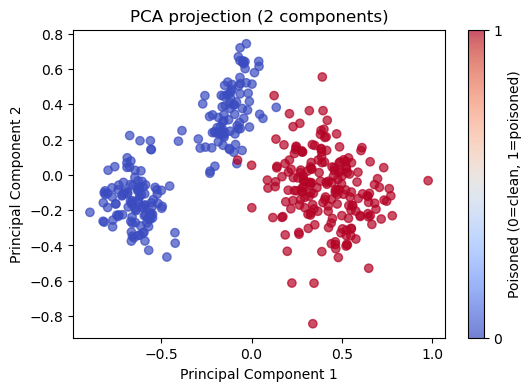

In [47]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Combine datasets and create labels
X = np.vstack([X_clean, X_poison])
y = np.concatenate([np.zeros(len(X_clean)), np.ones(len(X_poison))])

# 2. Apply PCA
pca = PCA(n_components=2)  # TODO: choose number of principal components (e.g., 2 for visualization)
X_pca = pca.fit_transform(X)

# 3. Check explained variance
print("Explained variance ratio of each component:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

# 4. Visualize the first two principal components
plt.figure(figsize=(6,4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA projection (2 components)')
plt.colorbar(ticks=[0,1], label='Poisoned (0=clean, 1=poisoned)')
plt.show()


Inline Comments: The code above combines the data and labels, then performs PCA. We print the explained variance ratios for each principal component — this tells us how much of the total variance in the data each component explains (for example, pca.explained_variance_ratio_[0] is the fraction of variance explained by PC1). Finally, we scatter-plot the data in the space of the first two principal components, coloring by the label to see if clean vs. poisoned points separate.

#### Reflection Questions:
* How well do the clean and poisoned samples separate along the first two principal components in the scatter plot? Do you observe distinct clusters or a lot of overlap?
* Look at the explained variance ratios. What portion of total variance is captured by PC1 and PC2? Given this, what does the variance capture in this context? (Think about whether the largest variance directions correspond to the clean/poison distinction or to other variation in the data.)
* If the clean vs. poisoned difference is a major source of variance, one of the top PCs might align with that difference. If it's not, what might that imply about how the poisoning affects the representations?

#### Follow-Up Task: Experiment with different numbers of principal components:

* Use PCA understand the data in 3D rather than 2D. How can you do this?
* Try increasing n_components (e.g., 5, 10, or more) and observe how the cumulative explained variance grows. How many components are needed to explain, say, 90% of the variance?
* Perform PCA separately on X_clean and X_poison individually. Compare the magnitude of variance in each dataset and the principal component vectors – are the top components in poisoned data different from those in clean data?

## 2. t-Distributed Stochastic Neighbor Embedding (t-SNE)

**Concept Overview**: t-SNE (t-Distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique, typically used for visualizing high-dimensional data in 2D or 3D. Unlike PCA which is linear, t-SNE is nonlinear, meaning it can capture complex relationships and separate data that cannot be separated by any straight line​. It works by trying to preserve local neighborhood structure: points that are close in the original high-dimensional space are projected to be close in the low-dimensional plot.

* One key parameter in t-SNE is perplexity, which can be thought of as a target for the number of nearest neighbors each point considers. In other words, "perplexity is more or less a target number of neighbors for our central point"​. 
* Formally, "Perplexity is an important hyperparameter for the t-SNE algorithm. It controls the effective number of neighbors that each point considers during the dimensionality reduction process."​
* A lower perplexity (e.g., 5) focuses on very local structure (small neighbor count), while a higher perplexity (e.g., 50) considers a broader neighborhood (capturing more global structure). Typical values range from 5 to 50. We often need to try a few different perplexity values to see which gives a clear visualization, as t-SNE's outcome can vary.

**Why use t-SNE here?** t-SNE is great for visualizing clusters or groups in data that might not be apparent with linear methods. In our context, we want to see if the clean and poisoned samples form separate clusters in representation space. If they do, t-SNE might show two distinct groups of points. If not, the points may be intermixed. We can also see if there's any complex structure (sub-clusters, manifold structure) in the data.

**Note**: t-SNE is computationally more intensive than PCA, but on 200 points it's fine. Also, t-SNE results can vary each run (due to random initialization), so we set a random_state for reproducibility.

We'll perform these steps:

1. Standardize or normalize the data if needed (t-SNE often works best if features are on similar scales; if our data are embeddings, they might already be roughly scaled, but we could consider using a standard scaler. Here we skip explicit scaling for simplicity).
2. Run t-SNE to reduce the 4096-dim data to 2 dimensions.
3. Visualize the resulting 2D embedding, coloring by clean/poisoned label.
4. Experiment with different perplexity values to see how the visualization changes.



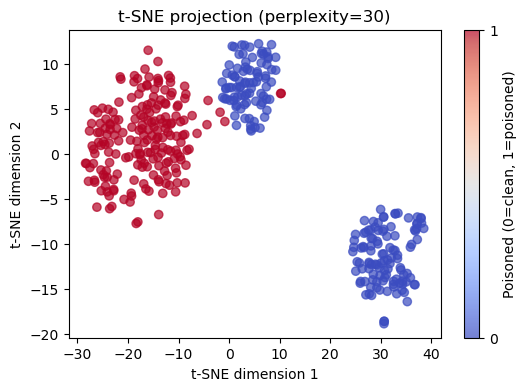

In [49]:
# Here's the template code for t-SNE. Fill in the ??? and run:

from sklearn.manifold import TSNE

# 1. Define t-SNE model
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # TODO: choose perplexity (e.g., 30 as a starting point)

# 2. Fit-transform the data using t-SNE (this may take a few seconds)
X_tsne = tsne.fit_transform(X)

# 3. Plot t-SNE results
plt.figure(figsize=(6,4))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title(f"t-SNE projection (perplexity={tsne.perplexity})")
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.colorbar(ticks=[0,1], label='Poisoned (0=clean, 1=poisoned)')
plt.show()

#### Reflection Questions:

1. Do the clean and poisoned samples form separate clusters in the t-SNE plot? Describe what you see: are there clear groupings, partial overlap, or complete mixing of the two classes?
2. How does the t-SNE visualization compare to the PCA visualization from the previous section? For example, if PCA didn't show clear separation but t-SNE does, what might that tell you about the structure of the data? (Hint: t-SNE can capture nonlinear separations​ so it might reveal clustering that PCA missed.)
3. Try changing the perplexity value in the code and re-running. What happens if you use a very low perplexity (e.g., 5) versus a higher one (e.g., 50)? 
4. Do the clusters become more or less apparent? Why do you think that is? (Remember: perplexity tunes the balance between local detail and global structure in the visualization.)


#### Follow-Up Task: Compare t-SNE to PCA:

1. Run t-SNE with a few different perplexities and maybe different random seeds. How stable are the clusters of clean vs. poisoned data? Does one setting make them cluster more distinctly?
2. If you have more than 2 dimensions of interest, you could try n_components=3 in t-SNE and visualize in 3D (or via pairwise plots).
3. Think about the differences: PCA gives a deterministic, globally linear view of variance, while t-SNE gives a nonlinear, local view of structure. Which one seems more effective for separating clean/poisoned data in this case, and what does that suggest about the nature of the "poison" effect on the representations?

## Persistent Homology (TDA)

**Concept Overview**: Topological Data Analysis (TDA) uses topology (the study of shape and space) to analyze datasets. One of its primary tools is persistent homology, which computes topological features (like connected components, loops, voids) of a data set across multiple scales​. In practical terms, imagine gradually "connecting" data points that are within a certain distance of each other: at first each point is isolated, then small clusters form, then clusters connect into bigger components, and so on. Persistent homology tracks when these features appear and disappear as the scale (distance threshold) changes – hence the terms "birth" and "death" of features. The output is often given as a persistence diagram or barcode, where each feature (0-dimensional components, 1-dimensional loops, etc.) is represented by a bar or a point indicating the scale at which it appears and disappears.

**Key points**:

1. H0 (0-dimensional homology): Connected components. As we increase the distance, points start to connect. A long-lasting connected component (one that persists until a large distance) indicates an isolated cluster that is far from others.
2. H1 (1-dimensional homology): Loops or cycles. This can indicate a ring-like structure in the data points. If a loop persists over a range of scales, it suggests a robust cycle in the shape of the point cloud.

One prominent tool within TDA is persistent homology, which tracks the birth and death of topological features across different scales, thereby capturing the multiscale behavior of a point cloud. More persistent (longer-lived) features are usually considered more significant (likely not noise)​.

Persistent Homology in LLM Interpretability: Recently, researchers have started to apply TDA to neural network representations (including LLMs) to understand their structure​. The idea is that the shape formed by activations or embeddings (like how clusters or loops form) can reveal something about how information is organized internally. For example, one might find that certain types of inputs form their own cluster or that there's a loop structure indicating a progression of states.

In this section, we will:

1. Compute the persistent homology of the raw high-dimensional data (without PCA or other reduction). We'll do this for clean data and poisoned data separately.
2. Compare the persistence diagrams to see if there are structural differences. For instance, perhaps the poisoned data introduces an additional cluster or a loop that the clean data doesn't have, or vice versa.
3. Interpret the results: do the diagrams suggest the presence of distinct clusters (long-lived H0 bars) or loops (H1 features) in one dataset vs the other?

We will use the ripser library (a popular tool for persistent homology in Python) to compute persistence diagrams. The output will be a list of persistence pairs for each homology dimension. We can use persim.plot_diagrams to plot the diagrams for visualization.

**Note**: Persistent homology can be computationally expensive for large datasets, but with 200 points and limiting to H1 it should be quick. We use maxdim=1 to compute 0D and 1D features only.


<!-- 
Here's the template code for computing and plotting persistence diagrams. Fill in the ??? where indicated:

!pip install ripser persim  # if not already installed, uncomment this line to install ripser and persim -->

from ripser import ripser
from persim import plot_diagrams

# 1. Compute persistence diagrams for clean data
result_clean = ripser(???, maxdim=1)   # TODO: provide the clean data array here (e.g., X_clean)
diagrams_clean = result_clean['dgms']

# 2. Compute persistence diagrams for poisoned data
result_poison = ripser(???, maxdim=1)  # TODO: provide the poisoned data array here (e.g., X_poison)
diagrams_poison = result_poison['dgms']

# 3. Plot the persistence diagrams for H0 and H1
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plot_diagrams(diagrams_clean, title="Clean Data Persistence")
plt.subplot(1, 2, 2)
plot_diagrams(diagrams_poison, title="Poisoned Data Persistence")
plt.show()
<!-- 
We use ripser(X, maxdim=1) to get H0 and H1. The result is a dictionary with 'dgms' containing a list of persistence pairs for each dimension. diagrams_clean[0] will be the list of (birth, death) pairs for H0 features (connected components), and diagrams_clean[1] for H1 features (loops). The plot_diagrams function from persim conveniently plots these pairs. Points near the diagonal line in a persistence diagram indicate short-lived features (likely noise), whereas points far from the diagonal indicate long-lived features (significant topological structure). -->

1. Logistic Regression Probe

Concept Overview: Logistic regression is a simple yet powerful classification algorithm. It finds a linear decision boundary (a hyperplane) that separates classes by maximizing the probability of the training labels. If the two classes are linearly separable – meaning there exists some hyperplane that perfectly separates them​
ds100.org
– then logistic regression (or any linear classifier) can achieve very high accuracy. If they are not linearly separable, a linear model will have limited accuracy.

In the context of neural network interpretability, training a probe (like a logistic regression classifier) on representations is a way to test what information those representations contain. For example, if you can train a logistic regression to distinguish clean vs. poisoned representations with high accuracy, it means the difference is linearly encoded in the representation space. Researchers often use such linear probes to measure if certain concepts (like linguistic features, or in this case the presence of a trojan trigger) are easily extractable from hidden layers of a model​
openreview.net
.

Put another way, we’re asking: Is the clean/poison feature linearly encoded in the 4096-dim representation? If yes, even a simple linear classifier will separate them. If no, then you might need a more complex model or the difference might be more subtle.

We will:

    Split the data into a training and test set (to evaluate generalization).
    Train a logistic regression classifier on the training data (X -> y, where y=0 for clean, 1 for poisoned).
    Evaluate it on the test data to get accuracy (or other metrics).
    Analyze whether the accuracy is high (near 100%) or much lower. High accuracy indicates linear separability of the classes​
    ds100.org
    ; random or low accuracy indicates they are mixed in the space (at least along any linear combination of features).
    Discuss what the result implies about the representations.

Let's implement this:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape[0], "Test set size:", X_test.shape[0])

# 2. Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# 3. Evaluate on test set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")

Inline Comments: We use train_test_split to randomly hold out 20% of the data for testing. The logistic regression (LogisticRegression) is initialized with max_iter=1000 just to ensure convergence (4096 features might require more iterations to converge). We then fit on the training data and predict on the test set. We output the accuracy as a simple measure of performance.

Reflection Questions:

    Is the accuracy close to 1.0 (100%), or is it significantly lower? What does this tell you about linear separability of the clean vs. poisoned representations? If you achieved a very high accuracy, it suggests that a linear decision boundary exists that distinguishes clean from poisoned data points. If the accuracy is low (around 0.5 which is random guessing for binary classes), it means the classes are mostly overlapping in this space and not linearly separable.
    Check the coefficients of the logistic regression (clf.coef_): Are many of them non-zero or large in magnitude? This could hint at which features (dimensions of the 4096 vector) contribute to the classification. (You could even examine the largest coefficients to see if certain dimensions are particularly important.)
    What are the implications of the dataset being (or not being) linearly separable? In terms of interpretability, if it's linearly separable, then the distinction between clean and poisoned data might be something as simple as a specific direction in feature space that correlates with the trojan trigger. If it's not, the difference might be more complex or diffuse in the representation.

Follow-Up Task: Try different classifiers and compare results:

    Train an SVM (Support Vector Machine) with a linear kernel and see if it does about the same as logistic regression (it should, if we properly adjusted C or if data is separable).
    Try a non-linear classifier: for example, an SVM with RBF kernel, or a Random Forest classifier. Do they perform significantly better than the logistic regression? If a non-linear model dramatically outperforms the linear model, that suggests the clean vs. poisoned separation is non-linear in the original space.
    If you have enough data, you could also try a simple neural network or a decision tree. The goal is to see if linear vs. non-linear models differ in their ability to separate the classes.
    Another idea: use the logistic regression as a probe for other layers or embeddings if you have them. For example, if these 4096-dim vectors came from a certain layer of an LLM, what about a different layer? Probing different layers can tell you where in the network the "poisonous" signal is easiest to detect.
    Relate this back to interpretability literature: Linear separability of hidden representations is often used as a sign that the network encodes a given concept explicitly​
    openreview.net
    . You can consider why a network might make a trojan trigger linearly accessible (perhaps because it's an out-of-distribution feature that stands out) or not.

5. Sparse Autoencoder (SAE) Feature Extraction

Concept Overview: An autoencoder is a type of neural network that learns to compress data into a lower-dimensional latent representation and then reconstruct it back to the original. It has two parts: an encoder that maps the input to a latent vector (feature space), and a decoder that maps the latent vector back to input space. By training it to minimize reconstruction error, the autoencoder is forced to learn meaningful features in the latent layer. These features often capture important factors of variation in the data (similar in spirit to PCA, but autoencoders can be nonlinear).

A sparse autoencoder (SAE) adds a constraint that the latent representation should be sparse – meaning most of the units (neurons) in the latent layer are zero (inactive) for any given input. This is usually achieved by adding a regularization term (like L1 penalty on activations or a KL-divergence sparsity penalty) that encourages the network to use as few neurons as possible for reconstruction. The result is that each neuron in the latent layer tends to specialize in representing a particular structure or concept in the input, making the features more interpretable and monosemantic​
openreview.net
. In the context of LLM interpretability, SAEs have been used to find meaningful directions in embedding space – for example, features that correspond to specific themes or triggers in the data​
openreview.net
. "Sparse Autoencoders (SAEs) are one of the most promising and popular methods for LLM interpretability and explainability."​
reddit.com

In this section, we'll build a simple sparse autoencoder on a small, easy-to-download dataset to demonstrate how it learns features. For the sake of a self-contained example, we'll use the scikit-learn digits dataset (which is like a small version of MNIST with 8x8 images of handwritten digits). This dataset is easy to load and train quickly. You could replace it with MNIST or another dataset if you want a more complex example (just be mindful of runtime).

Plan:

    Load the dataset and preprocess it (flatten images, scale pixel values to [0,1]).
    Define an autoencoder architecture using a library like TensorFlow/Keras (or PyTorch, etc.). We will use one hidden layer as our latent space (encoder) and one output layer (decoder). We'll incorporate an L1 activity regularizer on the latent layer to enforce sparsity.
    Train the autoencoder on the data (unsupervised, just trying to reconstruct its input).
    Analyze the learned features:
        We can look at the encoder's weights or visualize them to see what patterns each neuron detects.
        We can also examine how sparse the representations are (e.g., average percentage of neurons active for a given input).
        Check the reconstruction error to see how well it performs.
    Discuss how the sparsity constraint affects the features and reconstruction.

Let's implement the autoencoder for the digits dataset:

from sklearn.datasets import load_digits
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# 1. Load and preprocess the dataset (digits 8x8 images)
digits = load_digits()
X_img = digits.data  # shape (n_samples, 64), each sample is 8x8 image flattened
X_img = X_img / 16.0  # normalize pixel values (original range 0-16 for digits dataset)

input_dim = X_img.shape[1]  # 64 for digits
encoding_dim = 32  # size of latent space (number of features to learn)

# 2. Define the autoencoder model
# Encoder
input_layer = tf.keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu', 
                       activity_regularizer=regularizers.l1(1e-5))(input_layer)
# Decoder
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

# Complete autoencoder model
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoded)

# 3. Compile the model
autoencoder.compile(optimizer='adam', loss='mse')  # using mean squared error loss for reconstruction

# 4. Train the autoencoder
history = autoencoder.fit(X_img, X_img, 
                          epochs=???,        # TODO: choose number of epochs (e.g., 50)
                          batch_size=???,    # TODO: choose batch size (e.g., 32 or 64)
                          validation_split=0.1, verbose=0)
print("Training complete.")

Inline Comments: We used Keras to define a simple autoencoder. The encoder is one Dense layer with encoding_dim units and ReLU activation. We included activity_regularizer=regularizers.l1(1e-5) which adds a small L1 penalty on the activity of the layer (i.e., on the output of that layer, encouraging it to be sparse – many outputs near zero). The decoder is another Dense layer that reconstructs the original 64-dim input, using sigmoid activation (since we normalized inputs to 0-1). We compile with Adam optimizer and MSE loss. In fit, you need to fill in the epochs and batch_size. We also set aside 10% of data for validation to monitor reconstruction loss.

After training, let's evaluate and inspect what we've learned:

# 5. Evaluate reconstruction performance on the test set (here we'll just use the same data for simplicity)
reconstructions = autoencoder.predict(X_img)
mse_loss = np.mean(np.square(X_img - reconstructions))
print(f"Reconstruction MSE on training data: {mse_loss:.4f}")

# 6. Check sparsity of the encoded representations
# We'll use the encoder part to transform data
encoder_model = tf.keras.Model(inputs=input_layer, outputs=encoded)
X_encoded = encoder_model.predict(X_img)
# Calculate fraction of near-zero activations
sparse_frac = np.mean(np.abs(X_encoded) < 1e-3)
print(f"Fraction of latent activations that are ~0: {sparse_frac:.2f}")

# 7. Inspect some of the learned features (encoder weights)
weights, biases = autoencoder.layers[1].get_weights()  # layer[1] is the Dense layer for encoding
print("Encoder weight matrix shape:", weights.shape)   # (64, 32) for digits
# For each latent feature, we can see the weights as an 8x8 image patch:
feature_index = 0
print(f"Sample feature {feature_index} weights (reshaped to 8x8):")
print(weights[:, feature_index].reshape(8, 8))

<!-- This code gets the reconstructed outputs and computes the mean squared error to see how well the autoencoder learned. It then obtains the encoded representations of all data (X_encoded) and computes what fraction of values are very close to zero (within 1e-3). Ideally, with sparsity, a large fraction should be nearly zero. We also retrieve the encoder's weight matrix. Each of the 32 latent units has a weight vector of length 64 (one weight per input pixel). By reshaping this vector to 8x8, we can interpret it as an "image" or pattern that the neuron is looking for. (We printed one such weight map as a matrix; you could plot these as images for a better view if plotting images was enabled.) -->




Reflection Questions:

    Looking at the persistence diagrams for H0 (connected components): Do you see any points (or bars) that live much longer in one diagram compared to the other? For example, if in the poisoned data there's a point far from the diagonal in H0, it means there was an isolated cluster that didn't merge until a larger distance threshold. Is there a difference in how clustered or spread out the clean vs. poisoned data are?
    Now consider H1 (loops): Do either of the datasets show any persistent loops (points far from diagonal in the H1 diagram)? A loop would mean the data points formed a ring-like structure. If one of the datasets has a noticeable H1 feature and the other doesn't, that could indicate a structural difference introduced by the poisoning.
    In general, what structures persist across scales in each dataset? Are the important (persistent) topological features intuitive (e.g., one extra cluster or a particular shape)? Or are both datasets topologically similar?

Follow-Up Task: Try using persistent homology on PCA-reduced data instead of raw data:

    First, reduce the data to a lower dimension (say 10 or 20) using PCA, then run ripser on those reduced points. This can sometimes denoise or simplify the data, possibly making topological features clearer.
    Compare the persistence diagrams from PCA-reduced data to those from raw data. Did anything change in the presence or absence of certain features? (For example, maybe a subtle loop is lost or a cluster becomes more pronounced after PCA.)
    Consider other TDA parameters or techniques: for instance, you could try maxdim=2 to look for 2-dimensional voids (though with so few points, that's less likely to show up), or use a different distance metric (ripser supports Euclidean by default, but you could try cosine similarity matrix as input).
    For a deeper exploration, you might read about how persistent homology has been applied to neural network activations in research — it’s an emerging field that could yield interesting insights into model behavior.



Reflection Questions:

    What features does the autoencoder extract? Consider the weight matrices of the encoder: Each column of the weight matrix (or each latent neuron) corresponds to a feature. Do these features look like familiar patterns? (For example, in the digits dataset, an autoencoder might learn features like "stroke in the top-left corner" or "bottom loop of a digit", etc. If you were to visualize them, they might resemble pen strokes or fragment of digits.)
    Look at the sparsity fraction printed. Is it high (close to 1)? That would mean a lot of the latent values are near zero for each input. The goal of the regularizer was to make it high. If you find it's not that high, perhaps the regularization coefficient 1e-5 was too low. If it's extremely high and reconstruction error suffered, maybe it was too strong. It’s a balance.
    How does sparsity affect reconstruction? If you increased the regularization strength (make the L1 coefficient larger), what do you expect to happen to the reconstruction MSE? (Usually, more sparsity = using fewer features = likely higher reconstruction error, as the model can't use all its capacity to minimize error. Conversely, if you remove the sparsity penalty, you might get lower error but more entangled features.)
    In training the autoencoder, did the loss (MSE) decrease nicely? You could plot history.history['loss'] vs epochs to see. A stable convergence indicates it learned something. If the validation loss is much higher or diverging, it might be over-regularized or underfit.


Follow-Up Task: Further experiments with autoencoders:

    Try a different dataset: If you used the digits dataset here, try using the classic MNIST 28x28 digit dataset. You'd need to adjust the input dimensions and possibly increase the network size (and training epochs). With MNIST, you can see more interesting features (like strokes, curves) in a 784-dim -> (maybe 128-dim latent) autoencoder. Or try a small tabular dataset (like UCI Iris or a synthetic dataset) to see how an autoencoder deals with non-image data.
    Adjust the sparsity: Play with the activity_regularizer coefficient. What if you use regularizers.l1(1e-3) (stronger sparsity) or 1e-6 (weaker)? Observe the trade-off between sparsity and reconstruction error.
    Deeper autoencoder: We used a single hidden layer. Try adding one or two more layers in encoder and decoder (making it deep) to see if it learns different features or achieves lower reconstruction error. For example, encode to 64 -> 32 -> 16, then decode 16 -> 32 -> 64. You can still apply sparsity on one or more layers.
    Visualization: If possible, visualize some input reconstructions (e.g., show an original digit image and its reconstructed image) to qualitatively see what the autoencoder learned. Does it capture the main structure of the digit? Does it lose some details? This can give insight into which features are being prioritized.
    Reflect on how this ties back to LLM interpretability: In cutting-edge research, SAEs are used on actual LLM embedding vectors (not images) to discover interpretable features​
    openreview.net
    . The concepts are analogous; instead of strokes in an image, the features might be "the presence of a certain topic or token pattern". If you were to apply an SAE to the 4096-dim clean/poisoned representations, you might discover features that correspond to the trigger word or other meaningful latent factors. This could be a powerful way to dissect what dimensions or combinations of dimensions in the embedding are encoding the "poison."